## Exploratory Analysis (Time Series, etc.)
This is the time-series based analysis of the CAKE data. 

We have identified users that have reported technical difficulties during the CAKE experience, what behaviours do they present? 

More specifically, what did the participants report themselves:
- 109: "video wouldn't load so switched to read mode"
- 425: "videos very slow to load so ended up not watching"
- 407: "login didn't work"
- 205: "videos didn't play at all"
- 121: "wasn't clear how many oranges we needed"
- 112: "unable to view the videos"
- 220: "the video kept buffering, followed "read" instead"
- 217: "video didn't load so followed written instruction"
- 113: "the video didn't work, followed written instruction"
- 401: "video kept freezing"

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Firstly, let's import the techincal difficulties data (both the raw event data and the statistical data).

In [2]:
df_raw = pd.read_csv('./data/technical-difficult-interactions.csv')
df_stats = pd.read_csv('./data/technical-difficult-interactions_results.csv')

Currently, the timestamp column is an object. Let's convert it to a date time object, this will aid later in the process.

In [3]:
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

In terms of visualisation, let's first look at the total number of events recorded for each of these participants

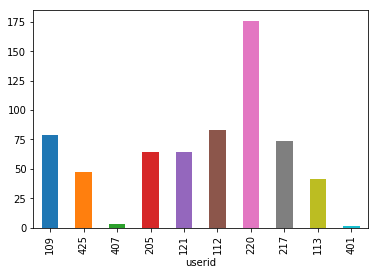

In [4]:
df_stats.plot(x='userid', y='totalEvents', kind='bar', legend=False)

Well, what does that tell us? Nothing, really. Notable things from this plot; 220 has a larger amount of recorded interactions, while both 401 and 407 have essentially none - the rest of the group are rougly around the same mark. Let's find out the descriptive statistics for the totalEvents.

In [5]:
df_stats['totalEvents'].describe()

count     10.000000
mean      63.200000
std       49.138806
min        1.000000
25%       42.500000
50%       64.000000
75%       77.750000
max      176.000000
Name: totalEvents, dtype: float64

So yes, the majority of users in this case hover around the mean of the totalEvents count. Presumably (I know, shouldn't really make presumptions without evidence) they all got to a particular point in the experience and gave up? In terms of comparison, let's have a look at the totalEvents for the interaction events collected during the live period of the experimental study.

In [6]:
df_live_stats = pd.read_csv('./data/live-interactions_statistics_results.csv')
df_live_stats['totalEvents'].describe()

count    116.000000
mean      45.810345
std       47.161132
min        1.000000
25%       10.000000
50%       38.500000
75%       62.250000
max      282.000000
Name: totalEvents, dtype: float64

So it's clear from above that the live data has a lower mean (when considering the total number of events per user). Does this show a trend? Possibly. There could be an argument that the higher (mean) number of events is just coincidental or that it shows people that experience technical difficulties produce, on average, a larger quantity of events.

Okay then, what about the length of time they spent on the experience? The statistical data is in __seconds__ so let's convert it to __minutes__ first and then plot.

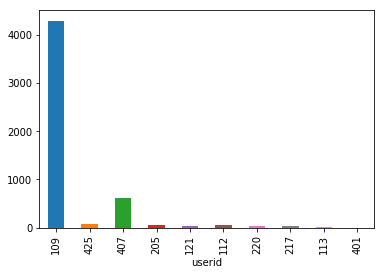

In [7]:
def get_mins(x):
    min, sec = divmod(x, 60)
    return float('{}.{}'.format(min, sec))

df_stats['totalTimeMin'] = df_stats['totalTime'].apply(get_mins)
df_stats.plot(x='userid', y='totalTimeMin', kind='bar', legend=False)

109 is definitely the larger interaction period. Let's have a look at the data to see exactly how much.

In [8]:
df_stats

,userid,totalEvents,totalTime,totalTimeBetweenClicks,meanTimeBetweenClicks,stdTimeBetweenClicks,meanClicksPerSecond,stdClicksPerSecond,meanClicksPerMinute,stdClicksPerMinute,mostFrequentItemAction,totalTimeMin
0,109,79,257396,257396,3258.177215,28521.065588,1.000000,0.000000,2.548387,2.419900,0 next_button,4289.56
1,425,47,4734,4734,100.723404,375.524080,1.021739,0.147442,2.473684,1.836918,1593921 window,78.54
2,407,3,36336,36336,12112.000000,20922.332972,1.000000,0.000000,1.000000,0.000000,0 play_pause_button,605.36
3,205,64,2819,2819,44.046875,94.748528,1.142857,0.483494,2.909091,2.810001,0 next_button,46.59
4,121,64,2592,2592,40.500000,124.163487,1.084746,0.384534,3.368421,3.832761,0 next_button,43.12
5,112,83,3722,3722,44.843373,93.581513,1.000000,0.000000,3.074074,2.758566,0 next_button,62.20
6,220,176,2005,2005,11.392045,56.014893,1.213793,0.699069,8.800000,7.804182,0 back_button,33.25
7,217,74,2207,2207,29.824324,54.856065,1.138462,0.428549,3.083333,3.386889,0 next_button,36.47
8,113,41,1167,1167,28.463415,67.725216,1.025000,0.158114,4.100000,3.871549,0 next_button,19.27
9,401,1,0,0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2147483647 v1,0.00


So we've identified the users that have had technical difficulties and the majority had video-related issues. Now, how do we model that? Furthermore, how do we also include the statistical information into the model.

Text(0,0.5,'number of events at the grouping')

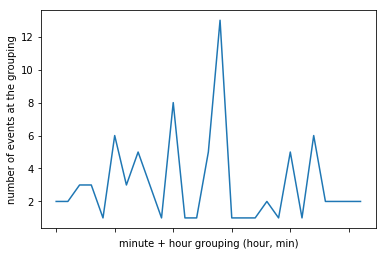

In [9]:
ax = df_raw[df_raw['participant_id'] == 112]['timestamp']\
.groupby([df_raw['timestamp'].dt.hour, df_raw['timestamp'].dt.minute])\
.count().plot()
ax.set_xlabel('minute + hour grouping (hour, min)')
ax.set_ylabel('number of events at the grouping')

***
### Exploring the sequences of actions performed by each of the participants
There are a few interesting questions that you can ask here.

Do we need to consider the next and back button? Does it really tell us anything in this context? What is noticable from the feedback given by the participants is that once they started having issues with the videos they just switched to the other view. 

Now, what if we just consider everything up until the first cardview toggle event? How many steps is this? What does the sequence look like in the build up?

The rationale behind this is two-fold; firstly, it's based on the feedback provided by the participants, and secondly, it reduces the sequence of item and action pairs -- currently the sequences are very long, and after they've switched views most participants just carry on with the task as normal.

In [10]:
# Create the combined column and convert it to an integer value using the Label Encoder
from sklearn import preprocessing
df_raw['combined'] = df_raw[['item', 'action']].apply(lambda x: ' '.join(x), axis=1)
le = preprocessing.LabelEncoder()
combined_encoded = le.fit_transform(df_raw['combined'].unique())
combined_dict = dict(zip(le.classes_, combined_encoded))
df_raw['combined_num'] = df_raw['combined'].map(combined_dict)
df_raw.head()

,id,participant_id,timestamp,pagetime,item,action,message,combined,combined_num
0,2251,109,2017-08-20 19:21:27,0,play_pause_button,play,NaN,play_pause_button play,9
1,2258,109,2017-08-20 19:26:34,0,full_screen_button,fullscreen,NaN,full_screen_button fullscreen,27
2,3059,425,2017-08-22 17:31:32,24156,window,blur,NaN,window blur,7
3,3060,425,2017-08-22 17:31:36,27647,window,focus,NaN,window focus,5
4,3061,425,2017-08-22 17:31:37,28958,v1,play,0 fullscreen=false,v1 play,8


***
### Statistical Exploration of the Data
This subset of the notebook is dedicated to exploring the statistical differences between the two sets of data (those with technical difficulties and those without). 

It'll apply techniques such as ANOVA, Parwise Comparisons, and maybe PCA.
- ANOVA: Used to determine whether there are any statistically significant differences between the means of the data.
- Pairwise comparison: *look up the meaning*

In [11]:
import scipy.stats as stats
df_live_stats = pd.read_csv('./data/live-interactions_statistics_results.csv')
df_live_stats['totalTimeMin'] = df_live_stats['totalTime'].apply(get_mins)
df_live_stats.drop(['sessionNo', 'mostFrequentItemAction'], inplace=True, axis=1) # just drop this for this bit.
df_stats.drop(['mostFrequentItemAction'], inplace=True, axis=1)

In [12]:
for col in df_stats.columns:
    if (col == 'userid') or (col == 'mostFrequentItemAction') or (col == 'label'):
        continue
    else:
        s, p = stats.f_oneway(df_live_stats[col], df_stats[col])
        print('{}, ({}, {})'.format(col, s, p))

totalEvents, (1.2439708345352691, 0.2668640254380009)
totalTime, (16.901387582354698, 7.109506845435359e-05)
totalTimeBetweenClicks, (16.901387582354698, 7.109506845435359e-05)
meanTimeBetweenClicks, (19.54986283806715, 2.116422752939854e-05)
stdTimeBetweenClicks, (27.738541948074598, 5.933438882315955e-07)
meanClicksPerSecond, (0.7300869683694365, 0.3945027731524635)
stdClicksPerSecond, (0.3022861981455943, 0.583441638199127)
meanClicksPerMinute, (0.0016800339990792111, 0.9673712120619895)
stdClicksPerMinute, (0.0028878743985271604, 0.9572296353561962)
totalTimeMin, (16.89481672223679, 7.131184973601627e-05)


In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Add labels
df_stats['label'] = 0
df_live_stats['label'] = 1

features = pd.concat([df_stats, df_live_stats], ignore_index=True)
y = features['label']
X = features.loc[:, 'totalEvents':'totalTimeMin']

X_norm = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns) # standardise

pca = PCA(n_components=2)
transformed = pd.DataFrame(pca.fit_transform(X_norm)) # apply PCA

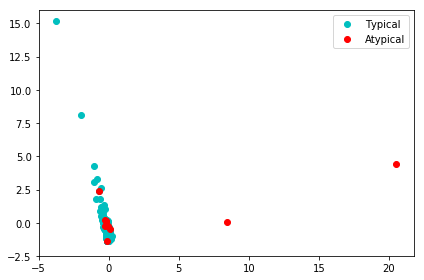

In [32]:
# Plot the PCA results
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Typical', c='c')
plt.scatter(transformed[y==0][0], transformed[y==0][1], label='Atypical', c='red')
plt.legend()
plt.tight_layout()
plt.savefig('pca_plot.png', dpi=300)

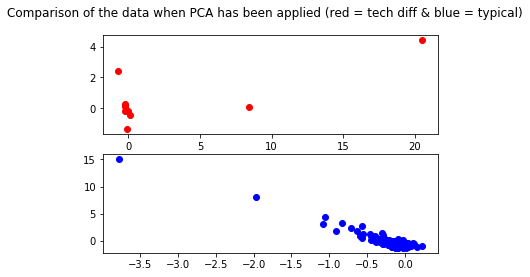

In [15]:
f, axarr = plt.subplots(2)
f.suptitle('Comparison of the data when PCA has been applied (red = tech diff & blue = typical)')
axarr[0].scatter(transformed[y==0][0], transformed[y==0][1], c='red')
axarr[1].scatter(transformed[y==1][0], transformed[y==1][1], c='c')

But how does the SMOTE over-sampling change this I wonder?

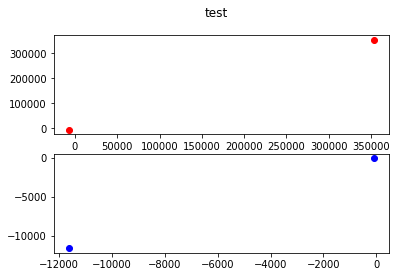

In [16]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(kind='svm').fit_sample(X, y)
X_resampled = pca.fit_transform(X_resampled)
f1, axarr2 = plt.subplots(2)
f1.suptitle('test')
axarr2[0].scatter(X_resampled[y_resampled==0][0], X_resampled[y_resampled==0][0], c='red')
axarr2[1].scatter(X_resampled[y_resampled==1][1], X_resampled[y_resampled==1][1], c='blue')

Post task clear up. Let's remove the label feature from the live stats.

In [17]:
df_live_stats.drop(['label'], axis=1, inplace=True)
df_stats.drop(['label'], axis=1, inplace=True)

***
### Comparison of Technical Difficulties vs Typical Users
The motivation here is to explore the differences between the two sets of users and to hopefully answer questions such as; do they look similar? Where do they differ? If they differ, then how and why? etc.

The first step is to remove the linear users from the live recorded data -- so we are only comparing those interactions that were recorded on CAKE. This removal has been done using an SQL query outside of the notebook (essentially just selected those with the condition = {1, 2}) but we still need to drop the condition from this new CSV file.

In [18]:
cake_data = pd.read_csv('./data/cake_alone_interactions.csv')
cake_data.drop(['id', 'condition'], axis=1, inplace=True)
cake_data.head()

,participant_id,timestamp,pagetime,item,action,message
0,206,2017-08-17 13:21:26,0,play_pause_button,play,NaN
1,206,2017-08-17 13:22:00,0,select_recipe,mullet,NaN
2,223,2017-08-17 14:12:35,0,play_pause_button,play,NaN
3,223,2017-08-17 14:13:14,0,select_recipe,mullet,NaN
4,223,2017-08-17 14:13:27,0,experience_level,not_really,NaN


In [19]:
# Select the statistics for the cake data users, ignoring the linear participants.
cake_data_stats = df_live_stats[df_live_stats['userid'].isin(cake_data['participant_id'].unique())]
cake_data_stats.head()

,userid,totalEvents,totalTime,totalTimeBetweenClicks,meanTimeBetweenClicks,stdTimeBetweenClicks,meanClicksPerSecond,stdClicksPerSecond,meanClicksPerMinute,stdClicksPerMinute,totalTimeMin
3,206,2,34,34,17.000000,24.041631,1.000000,0.000000,1.000000,0.000000,0.34
4,206,77,287,287,3.727273,6.229464,1.509804,0.880285,12.833333,15.223885,4.47
5,206,112,2776,2776,24.785714,36.817159,1.000000,0.000000,3.111111,2.538591,46.16
6,223,7,175,175,25.000000,30.697448,1.000000,0.000000,1.750000,0.957427,2.55
7,223,45,1782,1782,39.600000,37.250015,1.000000,0.000000,1.800000,1.080123,29.42


In [20]:
# Select the technical difficulties users that are cake users, ignoring the linear participants. It's worth noting that only two of the technical
# difficulty users are NOT cake participants.
cake_tech_diff_users = [109, 407, 205, 121, 112, 220, 217, 113]
cake_td_raw = df_raw[df_raw['participant_id'].isin(cake_tech_diff_users)]
cake_td_stats = df_stats[df_stats['userid'].isin(cake_tech_diff_users)]
cake_td_raw.to_csv('./data/cake_td_raw_data.csv', index=False)
cake_td_stats.to_csv('./data/cake_td_stats_data.csv', index=False)
#cake_td_raw.dtypes

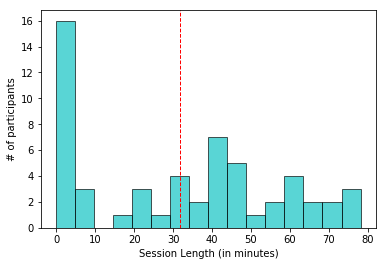

In [21]:
# Plot the histogram for the length of the session.
plt.figure()
plt.hist(cake_data_stats['totalTimeMin'], bins=16, edgecolor='k', alpha=0.65, color='c')
plt.xlabel('Session Length (in minutes)')
plt.ylabel('# of participants')
plt.axvline(cake_data_stats['totalTimeMin'].mean(), color='r', linestyle='dashed', linewidth=1)

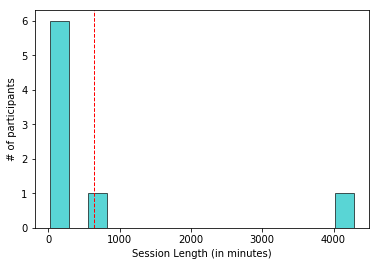

In [22]:
# Plot the histogram for the length of the session for technical difficulties users
plt.figure()
plt.hist(cake_td_stats['totalTimeMin'], bins=16, edgecolor='k', alpha=0.65, color='c')
plt.xlabel('Session Length (in minutes)')
plt.ylabel('# of participants')
plt.axvline(cake_td_stats['totalTimeMin'].mean(), color='r', linestyle='dashed', linewidth=1)

The above plot shows the histogram for the total time in minutes each of the participants (with technical difficulties) lastest. As is clear, one of the participants is skewing the data (109) -- let's try this plot without that user being included.

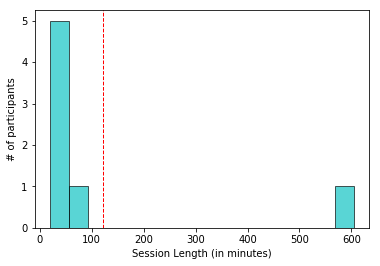

In [23]:
cake_td_stats = cake_td_stats.drop(cake_td_stats[cake_td_stats['userid'] == 109].index)
plt.figure()
plt.hist(cake_td_stats['totalTimeMin'], bins=16, edgecolor='k', alpha=0.65, color='c')
plt.xlabel('Session Length (in minutes)')
plt.ylabel('# of participants')
plt.axvline(cake_td_stats['totalTimeMin'].mean(), color='r', linestyle='dashed', linewidth=1)

Text(0,0.5,'# of participants')

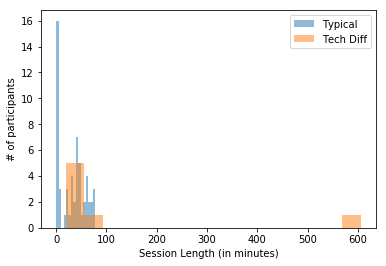

In [24]:
plt.figure()
plt.hist(cake_data_stats['totalTimeMin'], bins=16, alpha=0.5, label='Typical')
plt.hist(cake_td_stats['totalTimeMin'], bins=16, alpha=0.5, label='Tech Diff')
plt.legend()
plt.xlabel('Session Length (in minutes)')
plt.ylabel('# of participants')

So, now the problem seems to be that that the participant with ~600 minute long session (?...) is skewing the data so getting a proper comparison is hard. What does the above look like if we exlucude this participant as well...

It should be noted that this participant, 407, has only 3 events recorded!

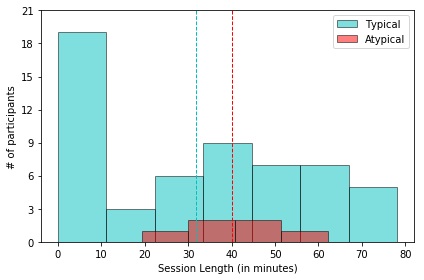

In [25]:
cake_td_stats = cake_td_stats.drop(cake_td_stats[cake_td_stats['userid'] == 407].index)
plt.figure()
plt.hist(cake_data_stats['totalTimeMin'], bins='auto', alpha=0.5, label='Typical', edgecolor='k', color='c')
plt.hist(cake_td_stats['totalTimeMin'], bins='auto', alpha=0.5, label='Atypical', edgecolor='k', color='r')
plt.legend()
plt.xlabel('Session Length (in minutes)')
plt.ylabel('# of participants')
plt.axvline(cake_td_stats['totalTimeMin'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(cake_data_stats['totalTimeMin'].mean(), color='c', linestyle='dashed', linewidth=1)
plt.yticks([0, 3, 6, 9, 12, 15, 18, 21])
plt.tight_layout()
plt.savefig('session-length-hist.png', dpi=300)

What does the above plot tell us? Well, from a session length perspective, and apart from the grouping of users on the left of the plot (those with much shorter sessions), that typical users that seem to take on average ~30 minutes while technical difficulties participants take ~40 minutes. The main point here is that from this perspective, they seem to be essentially the same.

In [27]:
# This code will produce a dictionary that has the signature: {id : [(5min increments, event count), ...]}. The idea for this is so we can 
# compare the number of events over time (see notebook for plot idea). This should probably be changed to a function.
from collections import defaultdict
def get_intensity_plot_data(dataframe, id_col_name, time_col_name, interval_period, time_period_str):
    plot_data = defaultdict(list)
    for uid in dataframe[id_col_name].unique():
        internal_df = pd.DataFrame(dataframe[dataframe[id_col_name] == uid])
        internal_df.set_index(time_col_name, inplace=True)
        internal_df.index = pd.to_datetime(internal_df.index)
        internal_df['count'] = 1
        internal_period = interval_period
        data = internal_df.groupby(pd.Grouper(freq=time_period_str)).aggregate(np.sum)
        for val in data['count']:
            plot_data[uid].append(tuple([internal_period, val]))
            internal_period += interval_period
    return plot_data

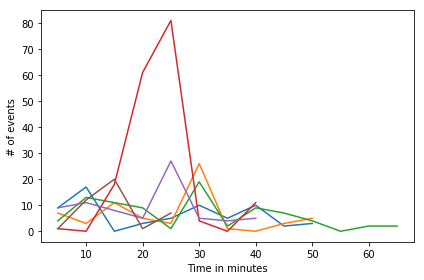

In [28]:
p_data = get_intensity_plot_data(cake_td_raw, 'participant_id', 'timestamp', interval_period=5, time_period_str='5min')
for k, v in p_data.items():
    if (k == 109) or (k == 407): # Let's just skip over these for the time being, they skew the plots terribly. 
        continue
    data = [(x, y) for x, y in v]
    plt.plot(*zip(*data), label=k)
    
plt.xlabel('Time in minutes')
_ = plt.ylabel('# of events')
plt.tight_layout()
plt.savefig('tech_diff_number_of_events_over_time.png', dpi=300)

The plot above is what Josh's essentially shows, now what happens if we apply this to the non-technical difficulties users.

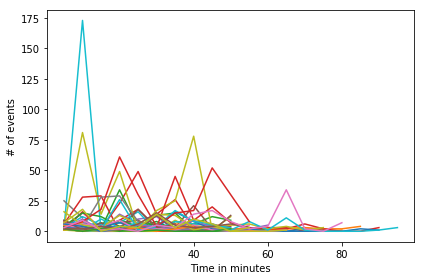

In [29]:
cake_data = cake_data.drop(cake_data[cake_data['participant_id'].isin(cake_tech_diff_users)].index) # remove TD people!

# Read in the raw data with the session number attached
cake_data_sess = pd.read_csv('./data/live-interactions_sessions.csv')

# Drop the technical difficulties users
cake_data_sess = cake_data_sess.drop(cake_data_sess[cake_data_sess['userId'].isin(cake_tech_diff_users)].index)

# Drop the non-CAKE participants!
cake_data_sess = cake_data_sess.drop(cake_data_sess[cake_data_sess['userId'].isin(cake_data['participant_id'].unique())].index)

# Concat the user id and session number to create a unique id for each session
cake_data_sess['comb_id_sess'] = cake_data_sess[['userId', 'sessionNo']].astype(str).apply(lambda x: ''.join(x), axis=1)

# plot.
non_td_data = get_intensity_plot_data(cake_data_sess, 'comb_id_sess', 'timestamp', interval_period=5, time_period_str='5min')
for k, v in non_td_data.items():
    data = [(x, y) for x, y in v]
    plt.plot(*zip(*data), label=k)
    
#plt.legend()
plt.xlabel('Time in minutes')
_ = plt.ylabel('# of events')
plt.xlim([0, 70])
plt.ylim([0, 40])
plt.tight_layout()
plt.savefig('typical-number-of-events-over-time.png', dpi=300)

So what do the two plots above tell us about the the data? Firstly, that the 'typical' users pattern of behaviour (with regards to the number of clicks at 5 minute intervals) is a bit of mess, however, there is definitely a sort of pattern to their behaviour with only a few participants ever going above the 25 events recorded in a 5 minute time window. This is a similar trend how with the technical difficulites users. 

I think what these two plots demonstrate is that the participants that experience technical difficulties are very difficult to tell apart from the rest of the 'typical' users of a system like CAKE -- even on this reduced and enclosed environment, with a small number of users. If this was scaled to the amount of data recorded in the origami experience then it's likely to be more of a mess (the key difference is being able to view things on a step-by-step basis).

Let's compare the item/actions between the two sets of data.

In [34]:
item_counts_td = cake_td_raw['item'].value_counts()
print(item_counts_td)
len(item_counts_td)

next_button           231
back_button           172
play_pause_button      43
cardView               41
full_screen_button     28
experience_level       14
select_recipe          14
cook_reason            14
cooking_for            14
confirm_cook            8
not_quite_button        5
Name: item, dtype: int64


11

In [35]:
cake_live_raw = pd.read_csv('./data/live-interactions.csv')

item_counts_live_raw = cake_live_raw['item'].value_counts()
print(item_counts_live_raw)
len(item_counts_live_raw)

v4                    1093
next_button            899
video_end              460
back_button            402
v1                     391
window                 345
v2                     321
play_pause_button      262
v3                     213
cardView               111
experience_level       102
cook_reason            100
cooking_for             99
select_recipe           92
full_screen_button      92
tab-r2                  85
tab-r3                  67
confirm_cook            59
tab-r1                  47
tab-finish              37
not_quite_button        36
tab-r4                   1
Name: item, dtype: int64


22

The above shows a remarkable difference between the two sets of users; those with technical difficulties have a smaller range of button types in their experience while those without experience the full interactivity of CAKE. A point that is worth noting, particularly with the technical difficulties participants, the number of times play_pause and cardView are click is roughly the same.

So this shows that as a result of experiencing technical difficulties, the participants have a *reduced* experience with CAKE.

In [33]:
"""Function to calculate the percentage change between the two sets of action counts"""
def get_change(live, td):
    if live == td:
        return 0
    try:
        return (abs(live - td) / td) * 100.0
    except ZeroDivisionError:
        return 0

change_result = {}
for k1, v1 in item_counts_td.iteritems():
    for k2, v2 in item_counts_live_raw.iteritems():
        if k1 == k2:
            change_result[k1] = get_change(v2, v1)         